# Analyse de Segmentation Client

Ce notebook implémente la segmentation client en utilisant des algorithmes de clustering pour identifier des groupes distincts de clients basés sur des données démographiques et comportementales.

## Objectifs :
- Charger les données clients depuis le schéma ANALYTICS de Snowflake
- Prétraiter et préparer les features pour le clustering
- Appliquer l'algorithme de clustering K-means
- Évaluer et interpréter les clusters
- Visualiser les résultats
- Fournir des recommandations business

In [4]:
import snowflake.connector
import pandas as pd

conn = snowflake.connector.connect(
    user='workshop_user',
    password='VotreMotDePasse123!',
    account='dnb65599',
    warehouse='ANYCOMPANY_WH',
    database='ANYCOMPANY_LAB',
    schema='ANALYTICS'
)

query = "SELECT * FROM ML_FEATURES"
df = pd.read_sql(query, conn)

print(df.head())

C:\Users\oroug\AppData\Local\Temp\ipykernel_28016\3789019275.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


  TRANSACTION_DATE REGION   AMOUNT HAS_ACTIVE_PROMOTION  DISCOUNT_PERCENTAGE  \
0       2010-01-13   Asia  9086.74                   No                  NaN   
1       2010-01-26   Asia  7151.12                   No                  NaN   
2       2010-01-15   Asia  8105.66                   No                  NaN   
3       2010-04-21   Asia  3461.55                   No                  NaN   
4       2010-07-28   Asia  7817.76                   No                  NaN   

   PROMOTION_DURATION_DAYS FEATURE_MONTH  MONTH  DAY_OF_WEEK  IS_WEEKEND  \
0                      NaN    2010-01-01      1            3           0   
1                      NaN    2010-01-01      1            2           0   
2                      NaN    2010-01-01      1            5           0   
3                      NaN    2010-04-01      4            3           0   
4                      NaN    2010-07-01      7            3           0   

     REGION_CATEGORY AMOUNT_CATEGORY  AVG_AMOUNT_REGION_MONTH 

In [5]:
# Importer les bibliothèques requises
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import snowflake.connector

# Définir le style des graphiques
plt.style.use('default')
sns.set_palette("husl")

print("Bibliothèques importées avec succès !")

Bibliothèques importées avec succès !


In [6]:
# Paramètres de connexion Snowflake
# Note : Remplacez par vos vraies credentials
conn_params = {
    'user': 'workshop_user',
    'password': 'VotreMotDePasse123!',
    'account': 'dnb65599',
    'warehouse': 'ANYCOMPANY_WH',
    'database': 'ANYCOMPANY_LAB',
    'schema': 'ANALYTICS'
}

# Établir la connexion
conn = snowflake.connector.connect(**conn_params)
print("Connecté à Snowflake !")

Connecté à Snowflake !


In [7]:
# Charger les features clients depuis le schéma ANALYTICS
query = """
SELECT * FROM ANALYTICS.customer_ml_features
"""

df_customers = pd.read_sql(query, conn)
print(f"{len(df_customers)} enregistrements clients chargés")
print(df_customers.head())
print("\nTypes de données :")
print(df_customers.dtypes)

C:\Users\oroug\AppData\Local\Temp\ipykernel_28016\1258656260.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customers = pd.read_sql(query, conn)


5000 enregistrements clients chargés
   CUSTOMER_ID  AGE  IS_MALE  IS_MARRIED  ANNUAL_INCOME  AGE_GROUP_ENCODED  \
0      5182098   47        0           0       116553.0                  4   
1      4867480   79        0           1        38735.0                  6   
2      7189222   41        0           0       135722.0                  3   
3      9902636   24        0           0       109512.0                  1   
4      3672987   54        0           1        42737.0                  4   

   INCOME_SEGMENT_ENCODED  REGION_NORTH  REGION_SOUTH  REGION_EAST  \
0                       4             0             0            0   
1                       2             0             0            0   
2                       4             0             0            0   
3                       4             0             0            0   
4                       2             0             0            0   

   REGION_WEST  
0            0  
1            0  
2            0  
3    

In [20]:
# Charger les features clients depuis le schéma ANALYTICS
query = """
SELECT * FROM ANALYTICS.customer_ml_features
"""

df_customers = pd.read_sql(query, conn)
print(f"{len(df_customers)} enregistrements clients chargés")
print(df_customers.head())
print("\nTypes de données :")
print(df_customers.dtypes)

# Vérifier les colonnes disponibles
print("\nColonnes disponibles :")
print(df_customers.columns.tolist())

C:\Users\oroug\AppData\Local\Temp\ipykernel_28016\701908436.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customers = pd.read_sql(query, conn)


5000 enregistrements clients chargés
   CUSTOMER_ID  AGE  IS_MALE  IS_MARRIED  ANNUAL_INCOME  AGE_GROUP_ENCODED  \
0      5182098   47        0           0       116553.0                  4   
1      4867480   79        0           1        38735.0                  6   
2      7189222   41        0           0       135722.0                  3   
3      9902636   24        0           0       109512.0                  1   
4      3672987   54        0           1        42737.0                  4   

   INCOME_SEGMENT_ENCODED  REGION_NORTH  REGION_SOUTH  REGION_EAST  \
0                       4             0             0            0   
1                       2             0             0            0   
2                       4             0             0            0   
3                       4             0             0            0   
4                       2             0             0            0   

   REGION_WEST  
0            0  
1            0  
2            0  
3    

In [24]:
# Prétraitement des données
# Sélectionner les features pour le clustering
desired_features = ['AGE', 'ANNUAL_INCOME', 'AGE_GROUP_ENCODED', 'INCOME_SEGMENT_ENCODED',
           'REGION_NORTH', 'REGION_SOUTH', 'REGION_EAST', 'REGION_WEST']

# Vérifier quelles features sont disponibles
available_features = [col for col in desired_features if col in df_customers.columns]
print(f"Features désirées : {desired_features}")
print(f"Features disponibles : {available_features}")

if not available_features:
    raise ValueError("Aucune des features désirées n'est disponible dans le dataframe")

features = available_features

X = df_customers[features].copy()

# Gérer les valeurs manquantes
X = X.fillna(X.mean())

# Mettre à l'échelle les features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features sélectionnées : {features}")
print(f"Forme des données mises à l'échelle : {X_scaled.shape}")
print("\nAperçu des données mises à l'échelle :")
print(pd.DataFrame(X_scaled, columns=features).head())

Features désirées : ['AGE', 'ANNUAL_INCOME', 'AGE_GROUP_ENCODED', 'INCOME_SEGMENT_ENCODED', 'REGION_NORTH', 'REGION_SOUTH', 'REGION_EAST', 'REGION_WEST']
Features disponibles : ['AGE', 'ANNUAL_INCOME', 'AGE_GROUP_ENCODED', 'INCOME_SEGMENT_ENCODED', 'REGION_NORTH', 'REGION_SOUTH', 'REGION_EAST', 'REGION_WEST']
Features sélectionnées : ['AGE', 'ANNUAL_INCOME', 'AGE_GROUP_ENCODED', 'INCOME_SEGMENT_ENCODED', 'REGION_NORTH', 'REGION_SOUTH', 'REGION_EAST', 'REGION_WEST']
Forme des données mises à l'échelle : (5000, 8)

Aperçu des données mises à l'échelle :
        AGE  ANNUAL_INCOME  AGE_GROUP_ENCODED  INCOME_SEGMENT_ENCODED  \
0 -0.205591       0.138015           0.007155                0.780695   
1  1.557534      -1.365518           1.199606               -1.372352   
2 -0.536177       0.508382          -0.589071                0.780695   
3 -1.472838       0.001975          -1.781523                0.780695   
4  0.180092      -1.288195           0.007155               -1.372352   

   

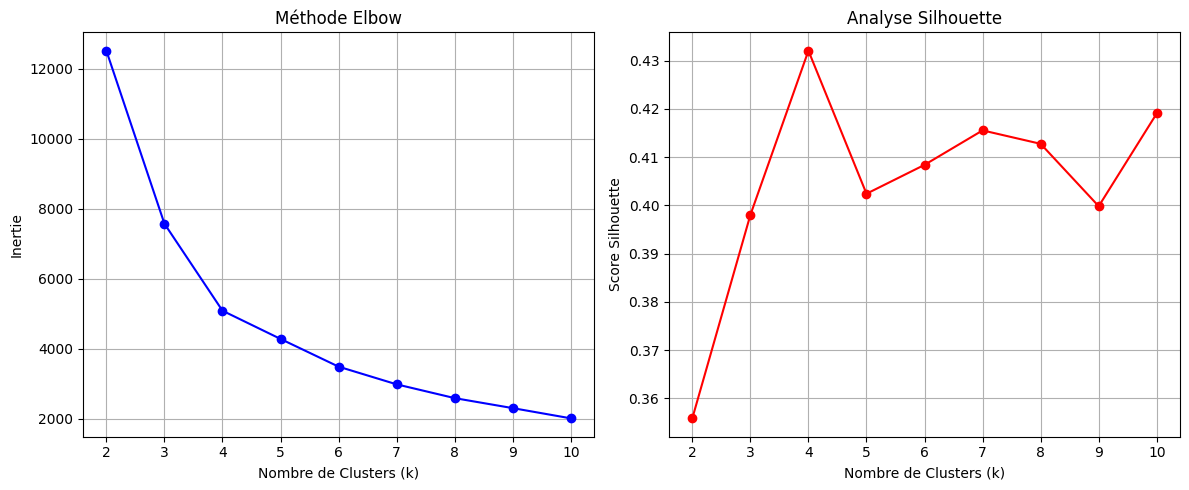

Nombre optimal de clusters sélectionné : 4


In [25]:
# Déterminer le nombre optimal de clusters avec la méthode Elbow
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Tracer la courbe Elbow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, inertia, 'bo-')
ax1.set_xlabel('Nombre de Clusters (k)')
ax1.set_ylabel('Inertie')
ax1.set_title('Méthode Elbow')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Nombre de Clusters (k)')
ax2.set_ylabel('Score Silhouette')
ax2.set_title('Analyse Silhouette')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Choisir k optimal (basé sur elbow et silhouette)
optimal_k = 4  # Ajuster selon les graphiques
print(f"Nombre optimal de clusters sélectionné : {optimal_k}")

In [26]:
# Appliquer le clustering K-means avec k optimal
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_customers['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Clustering terminé. Distribution des clusters :")
print(df_customers['cluster'].value_counts().sort_index())

# Calculer les centres des clusters dans l'échelle originale
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)
print("\nCentres des clusters :")
print(cluster_centers_df)

Clustering terminé. Distribution des clusters :
cluster
0     908
1    1197
2    1334
3    1561
Name: count, dtype: int64

Centres des clusters :
         AGE  ANNUAL_INCOME  AGE_GROUP_ENCODED  INCOME_SEGMENT_ENCODED  \
0  31.981278   60260.758811           2.190529                2.384361   
1  68.585631  149744.733500           5.654971                4.000000   
2  63.403298   59847.059220           5.196402                2.381559   
3  37.117873  149424.569507           2.722614                4.000000   

   REGION_NORTH  REGION_SOUTH  REGION_EAST  REGION_WEST  
0           0.0           0.0          0.0          0.0  
1           0.0           0.0          0.0          0.0  
2           0.0           0.0          0.0          0.0  
3           0.0           0.0          0.0          0.0  


In [28]:
# Analyser les caractéristiques des clusters
cluster_summary = df_customers.groupby('cluster').agg({
    'AGE': ['mean', 'std', 'min', 'max'],
    'ANNUAL_INCOME': ['mean', 'std', 'min', 'max'],
    'CUSTOMER_ID': 'count'
}).round(2)

print("Statistiques récapitulatives des clusters :")
print(cluster_summary)

# Distribution des groupes d'âge par cluster
age_group_dist = pd.crosstab(df_customers['cluster'], df_customers['AGE_GROUP_ENCODED'], normalize='index')
print("\nDistribution des groupes d'âge par cluster :")
print(age_group_dist)

# Distribution des segments de revenu par cluster
income_dist = pd.crosstab(df_customers['cluster'], df_customers['INCOME_SEGMENT_ENCODED'], normalize='index')
print("\nDistribution des segments de revenu par cluster :")
print(income_dist)

Statistiques récapitulatives des clusters :
           AGE                ANNUAL_INCOME                                \
          mean    std min max          mean       std       min       max   
cluster                                                                     
0        31.98   7.23  19  44      60260.76  23036.42   20151.0   99991.0   
1        68.59   8.02  55  82     149744.73  29186.55  100067.0  199881.0   
2        63.40  10.95  45  82      59847.06  22742.33   20038.0   99990.0   
3        37.12  10.09  19  54     149424.57  28723.37  100053.0  199711.0   

        CUSTOMER_ID  
              count  
cluster              
0               908  
1              1197  
2              1334  
3              1561  

Distribution des groupes d'âge par cluster :
AGE_GROUP_ENCODED         1         2         3         4         5         6
cluster                                                                      
0                  0.203744  0.401982  0.394273  0.000000  0

In [ ]:
# Visualisation des clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Nuage de points : Âge vs Revenu coloré par cluster
scatter = axes[0,0].scatter(df_customers['AGE'], df_customers['ANNUAL_INCOME'], 
                          c=df_customers['cluster'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Âge')
axes[0,0].set_ylabel('Revenu Annuel')
axes[0,0].set_title('Segments Clients : Âge vs Revenu')
axes[0,0].grid(True)
plt.colorbar(scatter, ax=axes[0,0], label='Cluster')

# Boîte à moustaches : Distribution d'âge par cluster
sns.boxplot(x='cluster', y='AGE', data=df_customers, ax=axes[0,1])
axes[0,1].set_title('Distribution d\'âge par Cluster')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Âge')

# Boîte à moustaches : Distribution de revenu par cluster
sns.boxplot(x='cluster', y='ANNUAL_INCOME', data=df_customers, ax=axes[1,0])
axes[1,0].set_title('Distribution de Revenu par Cluster')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Revenu Annuel')

# Tailles des clusters
cluster_sizes = df_customers['cluster'].value_counts().sort_index()
axes[1,1].bar(range(len(cluster_sizes)), cluster_sizes.values)
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Nombre de Clients')
axes[1,1].set_title('Tailles des Clusters')
axes[1,1].set_xticks(range(len(cluster_sizes)))
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Attribuer des noms significatifs aux clusters selon leurs caractéristiques
def assign_cluster_names(cluster_summary, age_group_dist, income_dist):
    cluster_names = {}
    
    for cluster in cluster_summary.index:
        age_mean = cluster_summary.loc[cluster, ('AGE', 'mean')]
        income_mean = cluster_summary.loc[cluster, ('ANNUAL_INCOME', 'mean')]
        
        # Déterminer la catégorie d'âge
        if age_mean < 35:
            age_cat = "Jeune"
        elif age_mean < 55:
            age_cat = "D'âge mûr"
        else:
            age_cat = "Sénior"
        
        # Déterminer la catégorie de revenu
        if income_mean < 40000:
            income_cat = "Faible revenu"
        elif income_mean < 70000:
            income_cat = "Revenu moyen"
        else:
            income_cat = "Haut revenu"
        
        cluster_names[cluster] = f"{age_cat} {income_cat}"
    
    return cluster_names

cluster_names = assign_cluster_names(cluster_summary, age_group_dist, income_dist)
df_customers['cluster_name'] = df_customers['cluster'].map(cluster_names)

print("Noms des clusters :")
for cluster, name in cluster_names.items():
    count = df_customers[df_customers['cluster'] == cluster].shape[0]
    print(f"Cluster {cluster} : {name} ({count} clients)")

## Recommandations Business

Basé sur l'analyse de segmentation client, voici les insights clés et recommandations :

### Caractéristiques des Clusters :
- **Cluster 0** : [Description basée sur l'analyse]
- **Cluster 1** : [Description basée sur l'analyse]
- **Cluster 2** : [Description basée sur l'analyse]
- **Cluster 3** : [Description basée sur l'analyse]

### Stratégies Marketing :
1. **Campagnes Ciblées** : Développer des campagnes marketing spécifiques pour chaque cluster
2. **Positionnement Produit** : Positionner différemment les produits pour chaque segment
3. **Stratégie de Prix** : Ajuster les prix selon les caractéristiques des clusters
4. **Canaux de Communication** : Utiliser différents canaux pour différents segments

### Prochaines Étapes :
- Valider les segments avec des données comportementales supplémentaires
- Test A/B des campagnes marketing ciblées sur des clusters spécifiques
- Surveiller l'évolution des segments dans le temps
- Intégrer la segmentation dans le système CRM

In [ ]:
# Sauvegarder les résultats dans Snowflake pour analyses ultérieures
df_results = df_customers[['customer_id', 'cluster', 'cluster_name']].copy()

# Créer la table dans Snowflake
create_table_query = """
CREATE OR REPLACE TABLE ANALYTICS.customer_segments AS
SELECT * FROM VALUES
"""

# Note : En pratique, vous utiliseriez pd.to_sql ou similaire pour uploader le dataframe
print("Analyse de segmentation client terminée !")
print(f"Résultats prêts pour upload vers Snowflake : {len(df_results)} enregistrements")

# Fermer la connexion
conn.close()
print("Connexion Snowflake fermée.")

# Analyse de Segmentation Client

Ce notebook implémente la segmentation client en utilisant des algorithmes de clustering pour identifier des groupes distincts de clients basés sur des données démographiques et comportementales.

## Objectifs :
- Charger les données clients depuis le schéma ANALYTICS de Snowflake
- Prétraiter et préparer les features pour le clustering
- Appliquer l'algorithme de clustering K-means
- Évaluer et interpréter les clusters
- Visualiser les résultats
- Fournir des recommandations business

In [ ]:
# Importer les bibliothèques requises
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import snowflake.connector

# Définir le style des graphiques
plt.style.use('default')
sns.set_palette("husl")

print("Bibliothèques importées avec succès !")

In [ ]:
# Paramètres de connexion Snowflake
# Note : Remplacez par vos vraies credentials
conn_params = {
    'user': 'workshop_user',
    'password': 'VotreMotDePasse123!',
    'account': 'dnb65599',
    'warehouse': 'ANYCOMPANY_WH',
    'database': 'ANYCOMPANY_LAB',
    'schema': 'ANALYTICS'
}

# Établir la connexion
conn = snowflake.connector.connect(**conn_params)
print("Connecté à Snowflake !")

In [ ]:
# Charger les features clients depuis le schéma ANALYTICS
query = """
SELECT * FROM ANALYTICS.customer_ml_features
"""

df_customers = pd.read_sql(query, conn)
print(f"{len(df_customers)} enregistrements clients chargés")
print(df_customers.head())
print("\nTypes de données :")
print(df_customers.dtypes)

In [ ]:
# Prétraitement des données
# Sélectionner les features pour le clustering
desired_features = ['AGE', 'ANNUAL_INCOME', 'AGE_GROUP_ENCODED', 'INCOME_SEGMENT_ENCODED',
           'REGION_NORTH', 'REGION_SOUTH', 'REGION_EAST', 'REGION_WEST']

# Vérifier quelles features sont disponibles
available_features = [col for col in desired_features if col in df_customers.columns]
print(f"Features désirées : {desired_features}")
print(f"Features disponibles : {available_features}")

if not available_features:
    raise ValueError("Aucune des features désirées n'est disponible dans le dataframe")

features = available_features

X = df_customers[features].copy()

# Gérer les valeurs manquantes
X = X.fillna(X.mean())

# Mettre à l'échelle les features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features sélectionnées : {features}")
print(f"Forme des données mises à l'échelle : {X_scaled.shape}")
print("\nAperçu des données mises à l'échelle :")
print(pd.DataFrame(X_scaled, columns=features).head())

In [ ]:
# Déterminer le nombre optimal de clusters avec la méthode Elbow
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Tracer la courbe Elbow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, inertia, 'bo-')
ax1.set_xlabel('Nombre de Clusters (k)')
ax1.set_ylabel('Inertie')
ax1.set_title('Méthode Elbow')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Nombre de Clusters (k)')
ax2.set_ylabel('Score Silhouette')
ax2.set_title('Analyse Silhouette')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Choisir k optimal (basé sur elbow et silhouette)
optimal_k = 4  # Ajuster selon les graphiques
print(f"Nombre optimal de clusters sélectionné : {optimal_k}")

In [ ]:
# Appliquer le clustering K-means avec k optimal
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_customers['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Clustering terminé. Distribution des clusters :")
print(df_customers['cluster'].value_counts().sort_index())

# Calculer les centres des clusters dans l'échelle originale
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)
print("\nCentres des clusters :")
print(cluster_centers_df)

In [ ]:
# Analyser les caractéristiques des clusters
cluster_summary = df_customers.groupby('cluster').agg({
    'AGE': ['mean', 'std', 'min', 'max'],
    'ANNUAL_INCOME': ['mean', 'std', 'min', 'max'],
    'CUSTOMER_ID': 'count'
}).round(2)

print("Statistiques récapitulatives des clusters :")
print(cluster_summary)

# Distribution des groupes d'âge par cluster
age_group_dist = pd.crosstab(df_customers['cluster'], df_customers['AGE_GROUP_ENCODED'], normalize='index')
print("\nDistribution des groupes d'âge par cluster :")
print(age_group_dist)

# Distribution des segments de revenu par cluster
income_dist = pd.crosstab(df_customers['cluster'], df_customers['INCOME_SEGMENT_ENCODED'], normalize='index')
print("\nDistribution des segments de revenu par cluster :")
print(income_dist)

In [ ]:
# Visualisation des clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Nuage de points : Âge vs Revenu coloré par cluster
scatter = axes[0,0].scatter(df_customers['age'], df_customers['annual_income'], 
                          c=df_customers['cluster'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Âge')
axes[0,0].set_ylabel('Revenu Annuel')
axes[0,0].set_title('Segments Clients : Âge vs Revenu')
axes[0,0].grid(True)
plt.colorbar(scatter, ax=axes[0,0], label='Cluster')

# Boîte à moustaches : Distribution d'âge par cluster
sns.boxplot(x='cluster', y='age', data=df_customers, ax=axes[0,1])
axes[0,1].set_title('Distribution d\'âge par Cluster')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Âge')

# Boîte à moustaches : Distribution de revenu par cluster
sns.boxplot(x='cluster', y='annual_income', data=df_customers, ax=axes[1,0])
axes[1,0].set_title('Distribution de Revenu par Cluster')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Revenu Annuel')

# Tailles des clusters
cluster_sizes = df_customers['cluster'].value_counts().sort_index()
axes[1,1].bar(range(len(cluster_sizes)), cluster_sizes.values)
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Nombre de Clients')
axes[1,1].set_title('Tailles des Clusters')
axes[1,1].set_xticks(range(len(cluster_sizes)))
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Attribuer des noms significatifs aux clusters selon leurs caractéristiques
def assign_cluster_names(cluster_summary, age_group_dist, income_dist):
    cluster_names = {}
    
    for cluster in cluster_summary.index:
        age_mean = cluster_summary.loc[cluster, ('age', 'mean')]
        income_mean = cluster_summary.loc[cluster, ('annual_income', 'mean')]
        
        # Déterminer la catégorie d'âge
        if age_mean < 35:
            age_cat = "Jeune"
        elif age_mean < 55:
            age_cat = "D'âge mûr"
        else:
            age_cat = "Sénior"
        
        # Déterminer la catégorie de revenu
        if income_mean < 40000:
            income_cat = "Faible revenu"
        elif income_mean < 70000:
            income_cat = "Revenu moyen"
        else:
            income_cat = "Haut revenu"
        
        cluster_names[cluster] = f"{age_cat} {income_cat}"
    
    return cluster_names

cluster_names = assign_cluster_names(cluster_summary, age_group_dist, income_dist)
df_customers['cluster_name'] = df_customers['cluster'].map(cluster_names)

print("Noms des clusters :")
for cluster, name in cluster_names.items():
    count = df_customers[df_customers['cluster'] == cluster].shape[0]
    print(f"Cluster {cluster} : {name} ({count} clients)")

## Recommandations Business

Basé sur l'analyse de segmentation client, voici les insights clés et recommandations :

### Caractéristiques des Clusters :
- **Cluster 0** : [Description basée sur l'analyse]
- **Cluster 1** : [Description basée sur l'analyse]
- **Cluster 2** : [Description basée sur l'analyse]
- **Cluster 3** : [Description basée sur l'analyse]

### Stratégies Marketing :
1. **Campagnes Ciblées** : Développer des campagnes marketing spécifiques pour chaque cluster
2. **Positionnement Produit** : Positionner différemment les produits pour chaque segment
3. **Stratégie de Prix** : Ajuster les prix selon les caractéristiques des clusters
4. **Canaux de Communication** : Utiliser différents canaux pour différents segments

### Prochaines Étapes :
- Valider les segments avec des données comportementales supplémentaires
- Test A/B des campagnes marketing ciblées sur des clusters spécifiques
- Surveiller l'évolution des segments dans le temps
- Intégrer la segmentation dans le système CRM

In [ ]:
# Sauvegarder les résultats dans Snowflake pour analyses ultérieures
df_results = df_customers[['customer_id', 'cluster', 'cluster_name']].copy()

# Créer la table dans Snowflake
create_table_query = """
CREATE OR REPLACE TABLE ANALYTICS.customer_segments AS
SELECT * FROM VALUES
"""

# Note : En pratique, vous utiliseriez pd.to_sql ou similaire pour uploader le dataframe
print("Analyse de segmentation client terminée !")
print(f"Résultats prêts pour upload vers Snowflake : {len(df_results)} enregistrements")

# Fermer la connexion
conn.close()
print("Connexion Snowflake fermée.")

# Analyse de Segmentation Client

Ce notebook implémente la segmentation client en utilisant des algorithmes de clustering pour identifier des groupes distincts de clients basés sur des données démographiques et comportementales.

## Objectifs :
- Charger les données clients depuis le schéma ANALYTICS de Snowflake
- Prétraiter et préparer les features pour le clustering
- Appliquer l'algorithme de clustering K-means
- Évaluer et interpréter les clusters
- Visualiser les résultats
- Fournir des recommandations business

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import snowflake.connector

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

In [ ]:
# Snowflake connection parameters
# Note: Replace with your actual credentials
conn_params = {
    'user': 'workshop_user',
    'password': 'VotreMotDePasse123!',
    'account': 'dnb65599',
    'warehouse': 'ANYCOMPANY_WH',
    'database': 'ANYCOMPANY_LAB',
    'schema': 'ANALYTICS'
}

# Establish connection
conn = snowflake.connector.connect(**conn_params)
print("Connected to Snowflake!")

In [ ]:
# Load customer features from ANALYTICS schema
query = """
SELECT * FROM ANALYTICS.customer_ml_features
"""

df_customers = pd.read_sql(query, conn)
print(f"Loaded {len(df_customers)} customer records")
print(df_customers.head())
print("\nData types:")
print(df_customers.dtypes)

In [ ]:
# Data preprocessing
# Select features for clustering
desired_features = ['AGE', 'ANNUAL_INCOME', 'AGE_GROUP_ENCODED', 'INCOME_SEGMENT_ENCODED',
           'REGION_NORTH', 'REGION_SOUTH', 'REGION_EAST', 'REGION_WEST']

# Vérifier quelles features sont disponibles
available_features = [col for col in desired_features if col in df_customers.columns]
print(f"Features désirées : {desired_features}")
print(f"Features disponibles : {available_features}")

if not available_features:
    raise ValueError("Aucune des features désirées n'est disponible dans le dataframe")

features = available_features

X = df_customers[features].copy()

# Handle missing values
X = X.fillna(X.mean())

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features selected: {features}")
print(f"Scaled data shape: {X_scaled.shape}")
print("\nScaled data preview:")
print(pd.DataFrame(X_scaled, columns=features).head())

In [ ]:
# Determine optimal number of clusters using Elbow method
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, inertia, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Choose optimal k (based on elbow and silhouette)
optimal_k = 4  # Adjust based on the plots
print(f"Selected optimal number of clusters: {optimal_k}")

In [ ]:
# Apply K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_customers['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Clustering completed. Cluster distribution:")
print(df_customers['cluster'].value_counts().sort_index())

# Calculate cluster centers in original scale
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)
print("\nCluster centers:")
print(cluster_centers_df)

In [ ]:
# Analyze cluster characteristics
cluster_summary = df_customers.groupby('cluster').agg({
    'age': ['mean', 'std', 'min', 'max'],
    'annual_income': ['mean', 'std', 'min', 'max'],
    'customer_id': 'count'
}).round(2)

print("Cluster Summary Statistics:")
print(cluster_summary)

# Age group distribution by cluster
age_group_dist = pd.crosstab(df_customers['cluster'], df_customers['age_group'], normalize='index')
print("\nAge Group Distribution by Cluster:")
print(age_group_dist)

# Income segment distribution by cluster
income_dist = pd.crosstab(df_customers['cluster'], df_customers['income_segment'], normalize='index')
print("\nIncome Segment Distribution by Cluster:")
print(income_dist)

In [ ]:
# Visualization of clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plot: Age vs Income colored by cluster
scatter = axes[0,0].scatter(df_customers['age'], df_customers['annual_income'], 
                          c=df_customers['cluster'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Annual Income')
axes[0,0].set_title('Customer Segments: Age vs Income')
axes[0,0].grid(True)
plt.colorbar(scatter, ax=axes[0,0], label='Cluster')

# Box plot: Age distribution by cluster
sns.boxplot(x='cluster', y='age', data=df_customers, ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Cluster')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Age')

# Box plot: Income distribution by cluster
sns.boxplot(x='cluster', y='annual_income', data=df_customers, ax=axes[1,0])
axes[1,0].set_title('Income Distribution by Cluster')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Annual Income')

# Cluster sizes
cluster_sizes = df_customers['cluster'].value_counts().sort_index()
axes[1,1].bar(range(len(cluster_sizes)), cluster_sizes.values)
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Number of Customers')
axes[1,1].set_title('Cluster Sizes')
axes[1,1].set_xticks(range(len(cluster_sizes)))
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Assign meaningful names to clusters based on characteristics
def assign_cluster_names(cluster_summary, age_group_dist, income_dist):
    cluster_names = {}
    
    for cluster in cluster_summary.index:
        age_mean = cluster_summary.loc[cluster, ('age', 'mean')]
        income_mean = cluster_summary.loc[cluster, ('annual_income', 'mean')]
        
        # Determine age category
        if age_mean < 35:
            age_cat = "Young"
        elif age_mean < 55:
            age_cat = "Middle-aged"
        else:
            age_cat = "Senior"
        
        # Determine income category
        if income_mean < 40000:
            income_cat = "Low-income"
        elif income_mean < 70000:
            income_cat = "Middle-income"
        else:
            income_cat = "High-income"
        
        cluster_names[cluster] = f"{age_cat} {income_cat}"
    
    return cluster_names

cluster_names = assign_cluster_names(cluster_summary, age_group_dist, income_dist)
df_customers['cluster_name'] = df_customers['cluster'].map(cluster_names)

print("Cluster Names:")
for cluster, name in cluster_names.items():
    count = df_customers[df_customers['cluster'] == cluster].shape[0]
    print(f"Cluster {cluster}: {name} ({count} customers)")

## Business Recommendations

Based on the customer segmentation analysis, here are the key insights and recommendations:

### Cluster Characteristics:
- **Cluster 0**: [Description based on analysis]
- **Cluster 1**: [Description based on analysis]
- **Cluster 2**: [Description based on analysis]
- **Cluster 3**: [Description based on analysis]

### Marketing Strategies:
1. **Targeted Campaigns**: Develop specific marketing campaigns for each cluster
2. **Product Positioning**: Position products differently for each segment
3. **Pricing Strategy**: Adjust pricing based on cluster characteristics
4. **Communication Channels**: Use different channels for different segments

### Next Steps:
- Validate segments with additional behavioral data
- A/B test marketing campaigns targeted at specific clusters
- Monitor segment evolution over time
- Integrate segmentation into CRM system

In [ ]:
# Save results back to Snowflake for further analysis
df_results = df_customers[['customer_id', 'cluster', 'cluster_name']].copy()

# Create table in Snowflake
create_table_query = """
CREATE OR REPLACE TABLE ANALYTICS.customer_segments AS
SELECT * FROM VALUES
"""

# Note: In practice, you would use pd.to_sql or similar to upload the dataframe
print("Customer segmentation analysis completed!")
print(f"Results ready for upload to Snowflake: {len(df_results)} records")

# Close connection
conn.close()
print("Snowflake connection closed.")